In [1]:
# -*- coding: utf-8 -*-
import os
os.environ['NLS_LANG'] = 'SIMPLIFIED CHINESE_CHINA.UTF8'
BASE_DIR = os.path.dirname(os.getcwd())
import sys
sys.path.append(BASE_DIR)
import time
import json
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.models as models
from tools.common_tools import get_vgg16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR


'C:\\Users\\Alvin\\Desktop\\sota_net\\02VGG\\VGG-代码\\B_VGG'

C:\Users\Alvin\Desktop\sota_net\02VGG\VGG-代码\B_VGG\Data\sample2.png
tensor([[[[-0.8164, -0.7993, -0.7993,  ...,  0.5364,  0.3994, -0.1486],
          [-0.8678, -0.8507, -0.8507,  ...,  0.0741, -0.3198, -0.7479],
          [-0.8849, -0.8678, -0.8678,  ..., -0.9705, -1.2445, -1.3987],
          ...,
          [-0.4397, -0.4226, -0.4054,  ...,  1.6153,  1.7180,  1.8037],
          [-0.4226, -0.4397, -0.4226,  ...,  1.5468,  1.6324,  1.7352],
          [-0.4226, -0.4397, -0.4397,  ...,  1.5297,  1.6153,  1.6838]],

         [[-0.8452, -0.8277, -0.8277,  ...,  0.2402,  0.1176, -0.3901],
          [-0.8978, -0.8803, -0.8803,  ..., -0.3550, -0.7052, -1.0903],
          [-0.9153, -0.8978, -0.8978,  ..., -1.3354, -1.5280, -1.6331],
          ...,
          [-0.0399, -0.0224, -0.0049,  ...,  1.5882,  1.6933,  1.7808],
          [-0.0224, -0.0399, -0.0224,  ...,  1.5182,  1.6057,  1.6933],
          [-0.0224, -0.0399, -0.0399,  ...,  1.5007,  1.5707,  1.6408]],

         [[-0.8633, -0.8458, -0.84

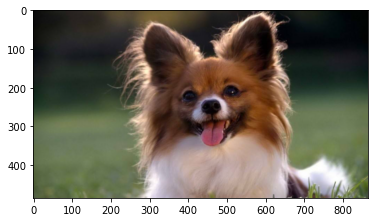

In [16]:
# 图片预处理
def img_transform(img_rgb, transform=None):
    """
    将数据转换为模型读取的形式
    :param img_rgb: PIL Image
    :param transform: torchvision.transform
    :return: tensor
    """

    if transform is None:
        raise ValueError("找不到transform！必须有transform对img进行处理")

    img_t = transform(img_rgb)
    return img_t


def process_img(path_img):

    # hard code
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    inference_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

    # path --> img
    img_rgb = Image.open(path_img).convert('RGB')

    # img --> tensor
    img_tensor = img_transform(img_rgb, inference_transform)
    img_tensor.unsqueeze_(0)        # chw --> bchw
    img_tensor = img_tensor.to(device)

    return img_tensor, img_rgb

# path_img = os.path.join(BASE_DIR, "..", "Data","Golden Retriever from baidu.jpg")
path_img = os.path.join(BASE_DIR,"Data","sample2.png")
print(path_img)
img_tensor, img_rgb = process_img(path_img)
print(img_tensor, img_tensor.shape)
print(img_rgb, img_rgb.size)
plt.imshow(img_rgb)


In [10]:
def load_class_names(p_clsnames, p_clsnames_cn):
    """
    加载标签名
    :param p_clsnames:
    :param p_clsnames_cn:
    :return:
    """
    with open(p_clsnames, "r") as f:
        class_names = json.load(f)
    with open(p_clsnames_cn, encoding='UTF-8') as f:  # 设置文件对象
        class_names_cn = f.readlines()
    return class_names, class_names_cn

path_classnames = os.path.join(BASE_DIR, "Data", "imagenet1000.json")
path_classnames_cn = os.path.join(BASE_DIR, "Data","imagenet_classnames.txt")

cls_n, cls_n_cn = load_class_names(path_classnames, path_classnames_cn)
print(cls_n)
print(cls_n_cn)

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bell toad, 

In [11]:
# load model
path_state_dict = os.path.join(BASE_DIR, "data", "vgg16-397923af.pth")
vgg_model = get_vgg16(path_state_dict, device, True)
print(path_state_dict)
print(vgg_model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [17]:
# %%timeit # 注意变量会被释放掉
# inference  tensor --> vector
with torch.no_grad():
    time_tic = time.time()
    outputs = vgg_model(img_tensor)
    time_toc = time.time()
    print("time consuming:{:.2f}s".format(time_toc - time_tic))
    print(outputs.shape)

time consuming:0.00s
torch.Size([1, 1000])


In [18]:
print(torch.topk(outputs.data, 5, dim=1))

torch.return_types.topk(
values=tensor([[17.8833, 16.5582, 13.2644, 12.6366, 12.2898]], device='cuda:0'),
indices=tensor([[157, 151, 259, 158, 152]], device='cuda:0'))


In [19]:
# 4/5 index to class names
_, pred_int = torch.max(outputs.data, 1)
_, top5_idx = torch.topk(outputs.data, 5, dim=1)

pred_idx = int(pred_int.cpu().numpy())
pred_str, pred_cn = cls_n[pred_idx], cls_n_cn[pred_idx]
print("img: {} is: {}\n\n{}".format(os.path.basename(path_img), pred_str, pred_cn))



img: sample2.png is: papillon

157 n02086910 狗, papillon



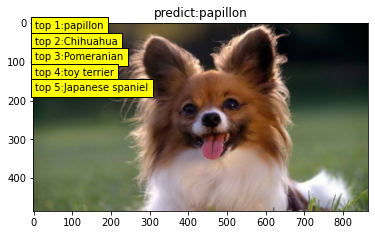

In [20]:
# 5/5 visualization
from matplotlib import pyplot as plt

plt.imshow(img_rgb)
plt.title("predict:{}".format(pred_str))
top5_num = top5_idx.cpu().numpy().squeeze()
text_str = [cls_n[t] for t in top5_num]
for idx in range(len(top5_num)):
    plt.text(5, 15+idx*40, "top {}:{}".format(idx+1, text_str[idx]), bbox=dict(fc='yellow'))
plt.show()